# Step0: Import Packages

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorwatch as tw
from sklearn import metrics
from torchviz import make_dot
from string import punctuation
import torch.nn.functional as F
from collections import Counter
from torchvision.models import AlexNet
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Step1: Get dataset

In [2]:
reviews = pd.read_csv("../data/english_yep_reviews.csv")

# Step2: Count the words

In [3]:
all_reviews = list(reviews['cleaned'])
all_text = " ".join(all_reviews)
all_words = all_text.split()
print(all_words[0:10])

# Count all the words using Counter Method
count_words = Counter(all_words)
total_words = len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : ", sorted_words[:10])

['someon', 'ha', 'work', 'mani', 'museum', 'wa', 'eager', 'visit', 'thi', 'galleri']
Top ten occuring words :  [('wa', 199857), ('thi', 86639), ('place', 55772), ('food', 53489), ('good', 50852), ('great', 44401), ('veri', 44062), ('time', 42695), ('get', 38251), ('would', 38160)]


# Step3: Create a dictionary

In [4]:
# Create a dictionary
# We will start createing dictionary with index 1 because 0 
    # is reserved for padding

vocab_to_int = {w: i+1 for i, (w, c) in enumerate(sorted_words)}

# Step4: Encode the review data

In [5]:
# Encode review
encoded_reviews = list()
for review in all_reviews:
    encoded_review = list()
    for word in review.split():
        if word not in vocab_to_int.keys():
            # if word is not available in vocab_to_int put 0 in that place
            encoded_review.append(0)
        else:
            encoded_review.append(vocab_to_int[word])
    encoded_reviews.append(encoded_review)

# Step5: Make the encode_review of the same length

In [6]:
# make all the encoded_review of the same length
# this step will return features of review_ints,
# where each review is padded with 0's or truncated to the input seq_length.
# the longest review has 564 words
# sequence_length is 100, but also could be 150, 200, 250 (here just for save energy)

sequence_length = 100
features = np.zeros((len(encoded_reviews), sequence_length), dtype=int)
for i, review in enumerate(encoded_reviews):
    review_len = len(review)
    if review_len <= sequence_length:
        zeros = list(np.zeros(sequence_length-review_len))
        new = zeros+review
    else:
        new = review[:sequence_length]
    features[i, :] = np.array(new)

# Step6: Create labels

In [7]:
# set labels, 0 negative, 1 neutral, 2 positive
labels = list(reviews['Review_Labels'])

# Step7: Split this feature data into Traning, Testing and Validation set

In [8]:
# split this feature data into training and validation set
# 80% training, 10% test and 10% validation dataset

# However, for cpu running, set 10% of them
# features = features[:int(0.5*len(features))]
# labels = labels[:int(0.5*len(labels))]
train_x = features[:int(0.8*len(features))]
train_y = labels[:int(0.8*len(features))]
valid_x = features[int(0.8*len(features)):int(0.9*len(features))]
valid_y = labels[int(0.8*len(features)):int(0.9*len(features))]
test_x = features[int(0.9*len(features)):]
test_y = labels[int(0.9*len(features)):]
print(len(train_y), len(valid_y), len(test_y))

79999 10000 10000


# Step8: Create DataLoader objects for Pytorch model

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
valid_data=TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
test_data=TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))

#dataloader
# remember to add drop_last=True, which will delete the last batch of the data if it's size is not equal to batch_size
batch_size=100
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

# Step9: Analyze the dataloader data

In [10]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([100, 100])
Sample input: 
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.6900e+02, 1.2660e+03,
         1.8480e+03],
        [4.6000e+01, 7.9800e+02, 4.0900e+02,  ..., 1.9000e+01, 5.4900e+02,
         4.5000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.6100e+02, 1.1600e+02,
         1.3680e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.7800e+02, 8.7600e+02,
         5.1000e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9060e+03, 1.0580e+03,
         1.7890e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2000e+01, 1.0000e+00,
         3.6240e+03]])
Sample label size:  torch.Size([100])
Sample label: 
 tensor([2., 2., 0., 2., 2., 0., 2., 2., 0., 2., 1., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 0., 0., 1., 2., 1., 2., 0.,
        2., 2., 2., 2., 2., 2., 0., 0., 0., 2., 0., 2., 2., 2., 2., 2., 2., 2.,
        0., 0., 2., 1., 2., 2., 2., 2., 2., 2., 2.,

# Step10-1: Create a Bi-LSTM models

In [11]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, output_size, embed, hidden_size, num_layers, num_classes, dropout, bidirectional):
        super(LSTM_Model, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed)
        self.lstm = nn.LSTM(embed, hidden_size, num_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)  # initialize Bi-LSTM model
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # This task only has three classes

    def forward(self, x):
        
        out = self.embedding(x)  # [batch_size, seq_len, embeding]=[100, 100, 300]
        out, _ = self.lstm(out)  # the output of lstm are out layer, c layer and hidden layer
        out = self.fc(out[:, -1, :])  # last hidden state of the sequence
        return out

# Step11-1: Initialize the Bi-LSTM models

In [36]:
# Instantiate the model w/ hperparams
vocab_size = len(vocab_to_int) + 1  # +1 for the 0 padding, 0.1 for the 10% of the total data (see step7)
output_size = 1
embed = 300
hidden_size = 25
num_layers = 2
dropout = 0.5
num_classes = 3
epochs = 10
bidirectional = False

model_bilstm = LSTM_Model(vocab_size, output_size, embed, hidden_size, num_layers, num_classes, dropout, True)
print('Bi-LSTM')
print(model_bilstm)


Bi-LSTM
LSTM_Model(
  (embedding): Embedding(77398, 300)
  (lstm): LSTM(300, 25, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


# Step12: Train the model

In [37]:
def train(epoch, model):
    lr = 0.0001  # learning rate
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    total_batch = 0
    train_loss = 0
    result_train_dict = {}
    result_valid_dict = {}
    epoch_train_list = []
    epoch_valid_list = []
    batch_train_list = []
    batch_valid_list = []
    loss_train_list = []
    loss_valid_list = []
    acc_train_list = []
    acc_valid_list = []
    f1_train_list = []
    f1_valid_list = []
    recall_train_list = []
    recall_valid_list = []
    for batch_idx, (trains, labels) in enumerate(train_loader):
        
        outputs = model(trains.long())
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        
        true = labels.data.cpu()
        predic = torch.max(outputs.data, 1)[1].cpu()
        train_acc = metrics.accuracy_score(true, predic)
        train_f1 = metrics.f1_score(true, predic, average='micro')
        train_recall = metrics.recall_score(true, predic, average='micro')
        loss_value = train_loss/(batch_idx+1)
        
        epoch_train_list.append(epoch)
        batch_train_list.append(batch_idx)
        loss_train_list.append(loss_value)
        acc_train_list.append(train_acc)
        f1_train_list.append(train_f1)
        recall_train_list.append(train_recall)

        if total_batch % 100 == 0 :
            
            for trains, labels in valid_loader:
                outputs = model(trains.long())
                valid_loss = F.cross_entropy(outputs, labels.long())
                
                true = labels.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                valid_acc = metrics.accuracy_score(true, predic)
                valid_f1 = metrics.f1_score(true, predic, average='micro')
                valid_recall = metrics.recall_score(true, predic, average='micro')
                
                epoch_valid_list.append(epoch)
                batch_valid_list.append(batch_idx)
                loss_valid_list.append(valid_loss.item())
                acc_valid_list.append(valid_acc)
                f1_valid_list.append(valid_f1)
                recall_valid_list.append(valid_recall)
                
                avg_acc_valid = np.array(acc_valid_list).mean()
                avg_loss_valid = np.array(loss_valid_list).mean()
                
            print('epoch: {}'.format(epoch), 'batch: {}'.format(batch_idx), 
                  'total train loader: {}'.format(len(train_loader)),
                  'T_Loss: %.3f | T_Acc: %.3f |' % (loss_value, train_acc),
                  'T_f1: %.3f | T_recall: %.3f ||' % (train_f1, train_recall),
                  'V_Loss: %.3f | V_Acc: %.3f' % (avg_loss_valid, avg_acc_valid),
                  'V_f1: %.3f | V_recall: %.3f' % (valid_f1, valid_recall))
        total_batch += 1
        
    result_train_dict['epoch'] = epoch_train_list
    result_train_dict['batch'] = batch_train_list
    result_train_dict['loss'] = loss_train_list
    result_train_dict['acc'] = acc_train_list
    result_train_dict['f1'] = f1_train_list
    result_train_dict['recall'] = recall_train_list
    
    result_valid_dict['epoch'] = epoch_valid_list
    result_valid_dict['batch'] = batch_valid_list
    result_valid_dict['loss'] = loss_valid_list
    result_valid_dict['acc'] = acc_valid_list
    result_valid_dict['f1'] = f1_valid_list
    result_valid_dict['recall'] = recall_valid_list
    
    pd_train = pd.DataFrame(result_train_dict)
    pd_valid = pd.DataFrame(result_valid_dict)

    return pd_train, pd_valid

## Step12-1. Bi-LSTM

In [38]:
epochs = 30
bilstm_train_result = pd.DataFrame()
bilstm_valid_result = pd.DataFrame()
for epoch in range(epochs):
    train_result, valid_result = train(epoch, model_bilstm)
    bilstm_train_result = bilstm_train_result.append(train_result, ignore_index=True)
    bilstm_valid_result = bilstm_valid_result.append(train_result, ignore_index=True)

epoch: 0 batch: 0 total train loader: 799 T_Loss: 1.136 | T_Acc: 0.190 | T_f1: 0.190 | T_recall: 0.190 || V_Loss: 1.133 | V_Acc: 0.164 V_f1: 0.150 | V_recall: 0.150
epoch: 0 batch: 100 total train loader: 799 T_Loss: 1.106 | T_Acc: 0.570 | T_f1: 0.570 | T_recall: 0.570 || V_Loss: 1.106 | V_Acc: 0.337 V_f1: 0.580 | V_recall: 0.580
epoch: 0 batch: 200 total train loader: 799 T_Loss: 1.076 | T_Acc: 0.750 | T_f1: 0.750 | T_recall: 0.750 || V_Loss: 1.072 | V_Acc: 0.447 V_f1: 0.700 | V_recall: 0.700
epoch: 0 batch: 300 total train loader: 799 T_Loss: 1.032 | T_Acc: 0.710 | T_f1: 0.710 | T_recall: 0.710 || V_Loss: 1.023 | V_Acc: 0.503 V_f1: 0.630 | V_recall: 0.630
epoch: 0 batch: 400 total train loader: 799 T_Loss: 0.983 | T_Acc: 0.660 | T_f1: 0.660 | T_recall: 0.660 || V_Loss: 0.984 | V_Acc: 0.536 V_f1: 0.690 | V_recall: 0.690
epoch: 0 batch: 500 total train loader: 799 T_Loss: 0.952 | T_Acc: 0.630 | T_f1: 0.630 | T_recall: 0.630 || V_Loss: 0.956 | V_Acc: 0.558 V_f1: 0.680 | V_recall: 0.680


epoch: 6 batch: 200 total train loader: 799 T_Loss: 0.507 | T_Acc: 0.870 | T_f1: 0.870 | T_recall: 0.870 || V_Loss: 0.524 | V_Acc: 0.805 V_f1: 0.870 | V_recall: 0.870
epoch: 6 batch: 300 total train loader: 799 T_Loss: 0.509 | T_Acc: 0.830 | T_f1: 0.830 | T_recall: 0.830 || V_Loss: 0.524 | V_Acc: 0.805 V_f1: 0.730 | V_recall: 0.730
epoch: 6 batch: 400 total train loader: 799 T_Loss: 0.508 | T_Acc: 0.810 | T_f1: 0.810 | T_recall: 0.810 || V_Loss: 0.524 | V_Acc: 0.805 V_f1: 0.900 | V_recall: 0.900
epoch: 6 batch: 500 total train loader: 799 T_Loss: 0.509 | T_Acc: 0.800 | T_f1: 0.800 | T_recall: 0.800 || V_Loss: 0.523 | V_Acc: 0.805 V_f1: 0.790 | V_recall: 0.790
epoch: 6 batch: 600 total train loader: 799 T_Loss: 0.510 | T_Acc: 0.770 | T_f1: 0.770 | T_recall: 0.770 || V_Loss: 0.521 | V_Acc: 0.806 V_f1: 0.780 | V_recall: 0.780
epoch: 6 batch: 700 total train loader: 799 T_Loss: 0.512 | T_Acc: 0.810 | T_f1: 0.810 | T_recall: 0.810 || V_Loss: 0.520 | V_Acc: 0.807 V_f1: 0.760 | V_recall: 0.76

epoch: 12 batch: 400 total train loader: 799 T_Loss: 0.450 | T_Acc: 0.810 | T_f1: 0.810 | T_recall: 0.810 || V_Loss: 0.473 | V_Acc: 0.822 V_f1: 0.790 | V_recall: 0.790
epoch: 12 batch: 500 total train loader: 799 T_Loss: 0.452 | T_Acc: 0.800 | T_f1: 0.800 | T_recall: 0.800 || V_Loss: 0.473 | V_Acc: 0.822 V_f1: 0.780 | V_recall: 0.780
epoch: 12 batch: 600 total train loader: 799 T_Loss: 0.453 | T_Acc: 0.770 | T_f1: 0.770 | T_recall: 0.770 || V_Loss: 0.473 | V_Acc: 0.822 V_f1: 0.770 | V_recall: 0.770
epoch: 12 batch: 700 total train loader: 799 T_Loss: 0.453 | T_Acc: 0.850 | T_f1: 0.850 | T_recall: 0.850 || V_Loss: 0.473 | V_Acc: 0.822 V_f1: 0.850 | V_recall: 0.850
epoch: 13 batch: 0 total train loader: 799 T_Loss: 0.337 | T_Acc: 0.860 | T_f1: 0.860 | T_recall: 0.860 || V_Loss: 0.472 | V_Acc: 0.821 V_f1: 0.830 | V_recall: 0.830
epoch: 13 batch: 100 total train loader: 799 T_Loss: 0.457 | T_Acc: 0.800 | T_f1: 0.800 | T_recall: 0.800 || V_Loss: 0.476 | V_Acc: 0.820 V_f1: 0.800 | V_recall: 

epoch: 18 batch: 500 total train loader: 799 T_Loss: 0.432 | T_Acc: 0.860 | T_f1: 0.860 | T_recall: 0.860 || V_Loss: 0.460 | V_Acc: 0.825 V_f1: 0.850 | V_recall: 0.850
epoch: 18 batch: 600 total train loader: 799 T_Loss: 0.432 | T_Acc: 0.840 | T_f1: 0.840 | T_recall: 0.840 || V_Loss: 0.461 | V_Acc: 0.825 V_f1: 0.830 | V_recall: 0.830
epoch: 18 batch: 700 total train loader: 799 T_Loss: 0.433 | T_Acc: 0.830 | T_f1: 0.830 | T_recall: 0.830 || V_Loss: 0.460 | V_Acc: 0.825 V_f1: 0.830 | V_recall: 0.830
epoch: 19 batch: 0 total train loader: 799 T_Loss: 0.392 | T_Acc: 0.880 | T_f1: 0.880 | T_recall: 0.880 || V_Loss: 0.457 | V_Acc: 0.826 V_f1: 0.780 | V_recall: 0.780
epoch: 19 batch: 100 total train loader: 799 T_Loss: 0.425 | T_Acc: 0.860 | T_f1: 0.860 | T_recall: 0.860 || V_Loss: 0.459 | V_Acc: 0.825 V_f1: 0.830 | V_recall: 0.830
epoch: 19 batch: 200 total train loader: 799 T_Loss: 0.431 | T_Acc: 0.800 | T_f1: 0.800 | T_recall: 0.800 || V_Loss: 0.460 | V_Acc: 0.825 V_f1: 0.830 | V_recall: 

epoch: 24 batch: 600 total train loader: 799 T_Loss: 0.403 | T_Acc: 0.810 | T_f1: 0.810 | T_recall: 0.810 || V_Loss: 0.439 | V_Acc: 0.831 V_f1: 0.830 | V_recall: 0.830
epoch: 24 batch: 700 total train loader: 799 T_Loss: 0.404 | T_Acc: 0.860 | T_f1: 0.860 | T_recall: 0.860 || V_Loss: 0.438 | V_Acc: 0.831 V_f1: 0.830 | V_recall: 0.830
epoch: 25 batch: 0 total train loader: 799 T_Loss: 0.373 | T_Acc: 0.840 | T_f1: 0.840 | T_recall: 0.840 || V_Loss: 0.439 | V_Acc: 0.832 V_f1: 0.790 | V_recall: 0.790
epoch: 25 batch: 100 total train loader: 799 T_Loss: 0.377 | T_Acc: 0.860 | T_f1: 0.860 | T_recall: 0.860 || V_Loss: 0.436 | V_Acc: 0.832 V_f1: 0.810 | V_recall: 0.810
epoch: 25 batch: 200 total train loader: 799 T_Loss: 0.380 | T_Acc: 0.840 | T_f1: 0.840 | T_recall: 0.840 || V_Loss: 0.435 | V_Acc: 0.833 V_f1: 0.810 | V_recall: 0.810
epoch: 25 batch: 300 total train loader: 799 T_Loss: 0.386 | T_Acc: 0.830 | T_f1: 0.830 | T_recall: 0.830 || V_Loss: 0.436 | V_Acc: 0.832 V_f1: 0.850 | V_recall: 

In [49]:
bilstm_train_result['roll_730_acc'] = bilstm_train_result['acc'].rolling(730).mean()
bilstm_valid_result['roll_730_acc'] = bilstm_valid_result['acc'].rolling(730).mean()
bilstm_train_result['roll_730_loss'] = bilstm_train_result['loss'].rolling(730).mean()
bilstm_valid_result['roll_730_loss'] = bilstm_valid_result['loss'].rolling(730).mean()

In [50]:
bilstm_train_result.to_csv('../result/Bi-LSTM/bilstm_train_result.csv')
bilstm_valid_result.to_csv('../result/Bi-LSTM/bilstm_valid_result.csv')

In [60]:
bilstm_valid_result.iloc[-1]

epoch             29.000000
batch            798.000000
loss               0.384338
acc                0.890000
f1                 0.890000
recall             0.890000
roll_730_acc       0.847507
roll_730_loss      0.384324
Name: 23969, dtype: float64

# Step13: Test the model

In [51]:
def test(epoch, model):
    lr = 0.001  # learning rate
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    total_batch = 0
    train_loss = 0
    result_dict = {}
    epoch_list = []
    batch_list = []
    loss_list = []
    acc_list = []
    recall_list = []
    f1_list = []
    
    for batch_idx, (trains, labels) in enumerate(test_loader):

        outputs = model(trains.long())
        test_loss = F.cross_entropy(outputs, labels.long())

        
        true = labels.data.cpu()
        predic = torch.max(outputs.data, 1)[1].cpu()
        test_acc = metrics.accuracy_score(true, predic)
        test_f1 = metrics.f1_score(true, predic, average='micro')
        test_recall = metrics.recall_score(true, predic, average='micro')
        
        epoch_list.append(epoch)
        batch_list.append(batch_idx)
        loss_list.append(test_loss.item())
        acc_list.append(test_acc)
        recall_list.append(test_recall)
        f1_list.append(test_f1)
            
        if total_batch % 50 == 0 :
            print('epoch: {}'.format(epoch), 'batch: {}'.format(batch_idx), 
                  'total train loader: {}'.format(len(test_loader)),
                  'Loss: %.3f | Acc: %.3f |' % (test_loss, test_acc),
                  'F1: %.3f | Recall: %.3f ' % (test_f1, test_recall))
        
#         total_batch += 1
        
    result_dict['epoch'] = epoch_list
    result_dict['batch'] = batch_list
    result_dict['loss'] = loss_list
    result_dict['acc'] = acc_list
    result_dict['f1'] = f1_list
    result_dict['recall'] = recall_list
    
    return pd.DataFrame(result_dict)

### Step13-1 Bi-LSTM model

In [52]:
bilstm_test_result = pd.DataFrame()
bilstm_test_result = bilstm_test_result.append(test(0, model_bilstm), ignore_index=True)


epoch: 0 batch: 0 total train loader: 100 Loss: 0.270 | Acc: 0.900 | F1: 0.900 | Recall: 0.900 
epoch: 0 batch: 1 total train loader: 100 Loss: 0.432 | Acc: 0.860 | F1: 0.860 | Recall: 0.860 
epoch: 0 batch: 2 total train loader: 100 Loss: 0.325 | Acc: 0.860 | F1: 0.860 | Recall: 0.860 
epoch: 0 batch: 3 total train loader: 100 Loss: 0.515 | Acc: 0.790 | F1: 0.790 | Recall: 0.790 
epoch: 0 batch: 4 total train loader: 100 Loss: 0.473 | Acc: 0.810 | F1: 0.810 | Recall: 0.810 
epoch: 0 batch: 5 total train loader: 100 Loss: 0.351 | Acc: 0.880 | F1: 0.880 | Recall: 0.880 
epoch: 0 batch: 6 total train loader: 100 Loss: 0.406 | Acc: 0.850 | F1: 0.850 | Recall: 0.850 
epoch: 0 batch: 7 total train loader: 100 Loss: 0.310 | Acc: 0.880 | F1: 0.880 | Recall: 0.880 
epoch: 0 batch: 8 total train loader: 100 Loss: 0.434 | Acc: 0.830 | F1: 0.830 | Recall: 0.830 
epoch: 0 batch: 9 total train loader: 100 Loss: 0.381 | Acc: 0.840 | F1: 0.840 | Recall: 0.840 
epoch: 0 batch: 10 total train loader: 1

epoch: 0 batch: 85 total train loader: 100 Loss: 0.333 | Acc: 0.880 | F1: 0.880 | Recall: 0.880 
epoch: 0 batch: 86 total train loader: 100 Loss: 0.327 | Acc: 0.900 | F1: 0.900 | Recall: 0.900 
epoch: 0 batch: 87 total train loader: 100 Loss: 0.422 | Acc: 0.820 | F1: 0.820 | Recall: 0.820 
epoch: 0 batch: 88 total train loader: 100 Loss: 0.540 | Acc: 0.780 | F1: 0.780 | Recall: 0.780 
epoch: 0 batch: 89 total train loader: 100 Loss: 0.599 | Acc: 0.820 | F1: 0.820 | Recall: 0.820 
epoch: 0 batch: 90 total train loader: 100 Loss: 0.394 | Acc: 0.850 | F1: 0.850 | Recall: 0.850 
epoch: 0 batch: 91 total train loader: 100 Loss: 0.384 | Acc: 0.840 | F1: 0.840 | Recall: 0.840 
epoch: 0 batch: 92 total train loader: 100 Loss: 0.358 | Acc: 0.840 | F1: 0.840 | Recall: 0.840 
epoch: 0 batch: 93 total train loader: 100 Loss: 0.436 | Acc: 0.830 | F1: 0.830 | Recall: 0.830 
epoch: 0 batch: 94 total train loader: 100 Loss: 0.440 | Acc: 0.840 | F1: 0.840 | Recall: 0.840 
epoch: 0 batch: 95 total train

In [53]:
bilstm_test_result.to_csv('../result/Bi-LSTM/bilstm_test_result.csv')

In [54]:
bilstm_test_result['acc'].mean()

0.8360999999999998

In [57]:
bilstm_test_result['f1'].mean()

0.8360999999999997

In [58]:
bilstm_test_result['recall'].mean()

0.8360999999999998

# Step14: plot the result

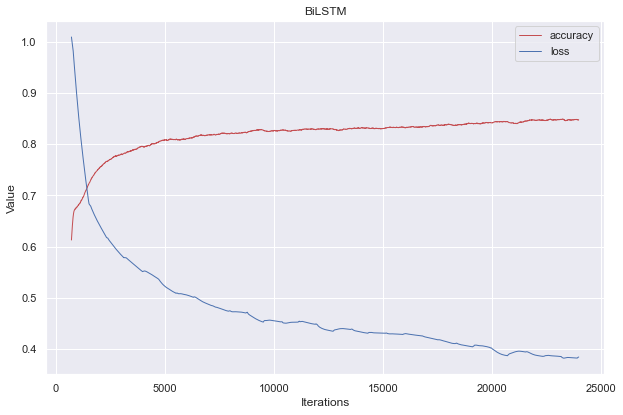

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

y1 = np.array(bilstm_train_result['roll_730_acc'])
y2 = np.array(bilstm_train_result['roll_730_loss'])

x = np.arange(len(y1))

plt.figure(figsize=(10, 6.5))

plt.plot(x, y1, color="r", linewidth=1, label='accuracy')
plt.plot(x, y2, color="b", linewidth=1, label='loss')

plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('BiLSTM')

plt.show()